# Analysis

## Data Cleaning

In [15]:
# Import libraries needed to clean and analyzee the data.
## data cleaning tools
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
## misc. data cleaning, analysis, notebook formatting tools
import boto3
import json
import random
import requests
from ipywidgets import widgets
import pickle
## machine learning tools
from scipy.stats import linregress
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [16]:
# set up comprehend for later API calls
comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')

# call in data from our S3 bucket
GA_cities = pd.read_csv("s3://marg-final/City_Data.csv")

# get all city options as a list
GA_cities_names = GA_cities.NAME.to_list()

# create random sample (n = 40) for experiments
random_cities = [random.choice(GA_cities_names) for i in range(40)]

# clean the data so only the cities' names are left (e.g., Decatur city, GA becomes Decatur)
random_cities_clean = [i.split()[0] for i in random_cities]

# Create test sentences in the format of: "I love <city name>, GA."
test_sentences = ["I love " + i + ", GA." for i in random_cities_clean]

# create a list of each sentences' length for testing
sentence_lengths = [len(i) for i in test_sentences]

# create a list of each sentences' city's population for testing
city_pop = GA_cities[GA_cities['NAME'].isin(random_cities)].B01001_001.to_list()

# use Comprehend to get each sentences' positive sentiment score
positive_score = [comprehend.detect_sentiment(Text=i, LanguageCode='en')["SentimentScore"]["Positive"] for i in test_sentences]

# create full dataframe with all relevant independent variables and the positive scores
test_set = pd.DataFrame(list(zip(sentence_lengths, positive_score, city_pop)), columns =['lnth', 'pos', 'population'])

# make sentiment scores easier to work with using a log transformation
log_pos = np.log(test_set.pos)
test_set["log_pos"] = log_pos

# make population easier to work with using z-score normalization
mean_pop = np.mean(city_pop)
sd_pop = np.std(city_pop)
pop_norm = []
for i in city_pop:
    pop_norm.append((i-mean_pop)/sd_pop)
test_set["pop_norm"] = pop_norm

In [17]:
## Cities used in this analysis
print("The cities used for the first two tests are:", random_cities_clean)

The cities used for the first two tests are: ['Hapeville', 'East', 'Swainsboro', 'East', 'Alapaha', 'Yatesville', 'Reynolds', 'Emerson', 'Portal', 'Reed', 'Vidette', 'Plains', 'Gay', 'Daisy', 'Stonecrest', 'Acworth', 'McDonough', 'Haralson', 'Concord', 'Decatur', 'Scottdale', 'Norwood', 'Offerman', 'Odum', 'Camilla', 'Butler', 'Rossville', 'Morganton', 'Meigs', 'McDonough', 'Conley', 'Demorest', 'Bowman', 'Fairmount', 'Culloden', 'Warwick', 'Peachtree', 'Funston', 'Ranger', 'Brunswick']


## Is city name length (as measured by test sentence length) related with the positive score value?


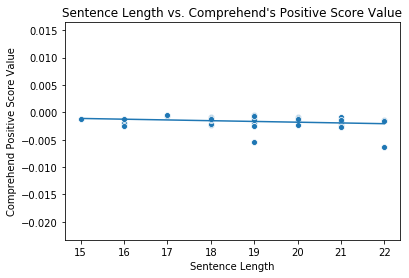

In [18]:
# Conduct linear regression comparing sentence length to the positive sentiment score value
## set up linear regression
res1 = linregress(test_set.lnth, test_set.log_pos)
## get range of data for line of best fit
fx = np.array([test_set.lnth.min(),  test_set.lnth.max()])
## create data points for plot range with line of best fit
fy = res1.intercept + res1.slope * fx

# Plot
## create base plot with sentence length vs. positive sentiment score value
ax = sns.scatterplot(x='lnth', y='log_pos', data= test_set)
## label titles
plt.xlabel("Sentence Length")
plt.ylabel("Comprehend Positive Score Value")
plt.title("Sentence Length vs. Comprehend's Positive Score Value")
## add line of best fit
plt.plot(fx, fy, '-')

## Is city population related with the positive score value?

Because of the risk of large outliers, we also did an analysis without the largest value.

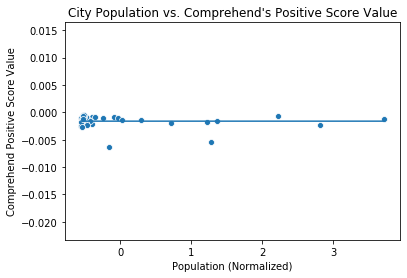

In [19]:
## ANALYSIS WITHOUT CONCERN OF OUTLIERS

# Conduct linear regression comparing sentence length to the positive sentiment score value
## set up linear regression
res2 = linregress(test_set.population, test_set.log_pos)
## get range of data for line of best fit
fx = np.array([test_set.pop_norm.min(),  test_set.pop_norm.max()])
## create data points for plot range with line of best fit
fy = res2.intercept + res2.slope * fx

# Plot
## create base plot with city population vs. positive sentiment score value
ax = sns.scatterplot(x='pop_norm', y='log_pos', data= test_set)
## label titles
plt.xlabel("Population (Normalized)")
plt.ylabel("Comprehend Positive Score Value")
plt.title("City Population vs. Comprehend's Positive Score Value")
## add line of best fit
plt.plot(fx, fy, '-')

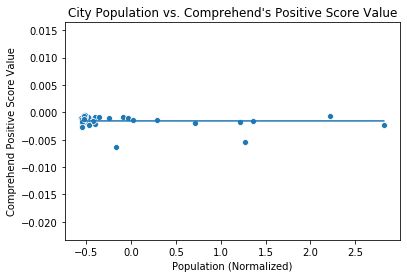

In [20]:
## ANALYSIS WHEN REMOVING OUTLIERS

# filter out largest city
test_set_outlier = test_set[test_set.population != test_set.nlargest(1, "population").population.to_list()[0]]

# Conduct linear regression comparing sentence length to the positive sentiment score value
## set up linear regression
res2 = linregress(test_set_outlier.population, test_set_outlier.log_pos)
## get range of data for line of best fit
fx = np.array([test_set_outlier.pop_norm.min(),  test_set_outlier.pop_norm.max()])
## create data points for plot range with line of best fit
fy = res2.intercept + res2.slope * fx

# Plot
## create base plot with city population vs. positive sentiment score value
ax = sns.scatterplot(x='pop_norm', y='log_pos', data= test_set_outlier)
## label titles
plt.xlabel("Population (Normalized)")
plt.ylabel("Comprehend Positive Score Value")
plt.title("City Population vs. Comprehend's Positive Score Value")
## add line of best fit
plt.plot(fx, fy, '-')

## Do similar cities have smaller positive test score differences than larger cities?

In [21]:
# create city pairs with a clustering algorithm
## convert dataset features into numpy array for normalization
features = GA_cities[["B01001_001", "B01001_002", "B02001_001", "B02001_003", "B19001_001","B19001_002", "B19001_003", "B19001_004", "B19001_005", "B19001_006", "B19001_007", "B19001_008", "B29001_001", "B29001_005"]].to_numpy()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## fit features to a nearest neighbors algorithm
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(scaled_features)
distances, indices = nbrs.kneighbors(scaled_features)

## test out nearest neighbor pairings
search_city = "Adairsville city, Georgia"
search_index = [i for i, val in enumerate(GA_cities.NAME == search_city) if val][0]
pair_index = indices[search_index][1]
pair_name = GA_cities.iloc[pair_index,:].NAME
pair_name

'Rossville city, Georgia'

In [22]:
# Choose 25 random cities
random_cities_test3 = [random.choice(GA_cities_names) for i in range(25)]

In [23]:
# Get Pairs from the clustering algorithm for each city
pairs = []
for x in random_cities_test3:
    search_index = [i for i, val in enumerate(GA_cities.NAME == x) if val][0]
    pair_index = indices[search_index][1]
    pair_name = GA_cities.iloc[pair_index,:].NAME
    pairs.append(pair_name)
    
# put pairs together
clust_city_pairs = [[pairs[i], random_cities_test3[i]] for i in range(len(pairs))]

# get random pairs for each city
random_cities_test3_pairs = [random.choice(GA_cities_names) for i in range(25)]
    
# put pairs together
rand_city_pairs = [[random_cities_test3_pairs[i], random_cities_test3[i]] for i in range(len(pairs))]

# clean all city names
clust_pairs_clean = []
for i in range(len(clust_city_pairs)):
    clust_pairs_clean.append([clust_city_pairs[i][0].split()[0],clust_city_pairs[i][1].split()[0]])

random_pairs_clean = []
for i in range(len(rand_city_pairs)):
    random_pairs_clean.append([rand_city_pairs[i][0].split()[0],rand_city_pairs[i][1].split()[0]])

# create test sentences
clust_sentences = []
for i in clust_pairs_clean:
    clust_sentences.append(["I love " + i[0] + ", GA.", "I love " + i[1] + ", GA."])

rand_sentences = []
for i in random_pairs_clean:
    rand_sentences.append(["I love " + i[0] + ", GA.", "I love " + i[1] + ", GA."])

In [24]:
# run all test sentences through Comprehend
## clustered sentences pairs
clust_pos_1 = [comprehend.detect_sentiment(Text=i[0], LanguageCode='en')["SentimentScore"]["Positive"] for i in clust_sentences]
clust_pos_2 = [comprehend.detect_sentiment(Text=i[1], LanguageCode='en')["SentimentScore"]["Positive"] for i in clust_sentences]

## random sentences pairs
rand_pos_1 = [comprehend.detect_sentiment(Text=i[0], LanguageCode='en')["SentimentScore"]["Positive"] for i in rand_sentences]
rand_pos_2 = [comprehend.detect_sentiment(Text=i[1], LanguageCode='en')["SentimentScore"]["Positive"] for i in rand_sentences]

# Get differences for each sample group
clust_diff = [clust_pos_1[i]-clust_pos_2[i] for i in range(len(clust_pos_1))]
rand_diff = [rand_pos_1[i]-rand_pos_2[i] for i in range(len(clust_pos_1))]

# Conduct t-test
diff_in_mean = (np.mean(rand_diff)-np.mean(clust_diff))
denom = np.sqrt(((np.std(rand_diff)**2)/len(rand_diff)) + ((np.std(clust_diff)**2)/len(clust_diff)))
t = diff_in_mean/denom
df = len(clust_diff)-1
print(t, df)

1.0897526777843611 24


In [25]:
## Cities used in this analysis
print("The clustered pairs are:", clust_city_pairs, "\n \n The random pairs are:", rand_city_pairs)

The clustered pairs are: [['Morven city, Georgia', 'Lincoln Park CDP, Georgia'], ['Walnut Grove city, Georgia', 'Emerson city, Georgia'], ['Lincolnton city, Georgia', 'Pearson city, Georgia'], ['Homeland city, Georgia', 'Waverly Hall town, Georgia'], ['Cordele city, Georgia', 'Fitzgerald city, Georgia'], ['Midway city, Georgia', 'Kings Bay Base CDP, Georgia'], ['Augusta-Richmond County consolidated government (balance), Georgia', 'Atlanta city, Georgia'], ['Girard town, Georgia', 'Rebecca town, Georgia'], ['Avalon town, Georgia', 'Cedar Springs CDP, Georgia'], ['Hogansville city, Georgia', 'Sylvania city, Georgia'], ['Pavo city, Georgia', 'Adrian city, Georgia'], ['Crooked Creek CDP, Georgia', 'Good Hope city, Georgia'], ['Calvary CDP, Georgia', 'Matthews CDP, Georgia'], ['Adel city, Georgia', 'Eastman city, Georgia'], ['Nahunta city, Georgia', 'Doerun city, Georgia'], ['Griffin city, Georgia', 'LaGrange city, Georgia'], ['Lawrenceville city, Georgia', 'Kennesaw city, Georgia'], ['Dunw

# Coded for Application of Algorithm to Reddit Research

## Code to generate the sample data for our showcase.

In [ ]:
## use for loop to pull data for all GA cities from pushshift API
full_posts, full_sentiment, full_time = [], [], []
for x in GA_cities.NAME[:150]:
    ## create request
    web_cleaned = x.split(",")[0].replace(" ", "%20")
    url = "https://api.pushshift.io/reddit/search/comment/?q=" + web_cleaned + "%20GA"
    request = requests.get(url)
    json_response = request.json()
    
    ## store the post, time, and sentiment score for each iteration
    city_1_posts = [i['body'][:500] for i in json_response['data']]
    city_1_time = [i['created_utc'] for i in json_response['data']]
    city_1_sentiments = [comprehend.detect_sentiment(Text=i[0], LanguageCode='en')['SentimentScore']['Positive'] for i in city_1_posts]
    
    ## create large list of all data
    full_posts.append(city_1_posts)
    full_time.append(city_1_time)
    full_sentiment.append(city_1_sentiments)
    
# create list of dicts to use (we will get the appropriate data using indices)
full_scores = [dict(zip(full_time[i], full_sentiment[i])) for i in range(len(full_sentiment))]

# Save GA city data for future access
ga_city_samples = GA_cities.NAME.to_list()[:150]
test = json.dumps(ga_city_samples)
with open('GA_city_sample.txt', 'w') as outfile:
    json.dump(test, outfile)
    
# Save Comprehend data for future access
test = json.dumps(full_scores)
with open('sample Reddit data.txt', 'w') as outfile:
    json.dump(test, outfile)

## Code to create real-time comparator dashboard.

In [14]:
## CODE FOR CLUSTER-BASED COMPARISON
city_choice = widgets.Dropdown(options=GA_cities.NAME.to_list(), 
                               value=GA_cities.NAME.to_list()[0],
                               description='Choose a city:',
                               disabled=False)
display(city_choice) 

submit_button = widgets.Button(description = "Get Results!")
display(submit_button)

def handle_submit(sender):
    # Give a time warning
    print("We are analyzing your results. There is a lot of data to comb through, one second!")
    
    # Get pair cities
    search_city = city_choice.value    
    search_index = [i for i, val in enumerate(GA_cities.NAME == search_city) if val][0]
    pair_index = indices[search_index][1]
    pair_name = GA_cities.iloc[pair_index,:].NAME
    
    # Get web-ready place names
    search_city2 = search_city.split(",")[0].replace(" ", "%20")
    pair_city2 = pair_name.split(",")[0].replace(" ", "%20")
    
    # Get first cities' reddit data
    url = "https://api.pushshift.io/reddit/search/comment/?q=" + search_city2 + "%20GA"
    request = requests.get(url)
    json_response = request.json()
    
    city_1_posts = []
    city_1_time = []
    
    for i in json_response['data']:
        city_1_posts.append([i['body'][:500]])
        city_1_time.append(i['created_utc'])
        
    first_posts_pos, first_posts_neg, first_posts_neu, first_posts_mix = [], [], [], []
    
    for i in city_1_posts:
        first_posts_pos.append(comprehend.detect_sentiment(Text=i[0], LanguageCode='en')['SentimentScore']['Positive'])
        first_posts_neg.append(comprehend.detect_sentiment(Text=i[0], LanguageCode='en')['SentimentScore']['Negative'])
        first_posts_neu.append(comprehend.detect_sentiment(Text=i[0], LanguageCode='en')['SentimentScore']['Neutral'])
        first_posts_mix.append(comprehend.detect_sentiment(Text=i[0], LanguageCode='en')['SentimentScore']['Mixed'])
        
    combined_dict = {'time': city_1_time, 'pos': first_posts_pos, 
                     'neg': first_posts_neg, 'neu': first_posts_neu, 'mix': first_posts_mix}
    
    first_city = pd.DataFrame(data = combined_dict)
    first_plot = first_city.plot(x = "time", y = ['pos', 'neg'])
    print(first_plot)
    
    # Get second cities' reddit data
    url = "https://api.pushshift.io/reddit/search/comment/?q=" + pair_city2 + "%20GA"
    request = requests.get(url)
    json_response = request.json()
    
    city_2_posts = []
    city_2_time = []
    
    for i in json_response['data']:
        city_2_posts.append([i['body'][:500]])
        city_2_time.append(i['created_utc'])
        
    sec_posts_pos, sec_posts_neg, sec_posts_neu, sec_posts_mix = [], [], [], []
    
    for i in city_2_posts:
        sec_posts_pos.append(comprehend.detect_sentiment(Text=i[0], LanguageCode='en')['SentimentScore']['Positive'])
        sec_posts_neg.append(comprehend.detect_sentiment(Text=i[0], LanguageCode='en')['SentimentScore']['Negative'])
        sec_posts_neu.append(comprehend.detect_sentiment(Text=i[0], LanguageCode='en')['SentimentScore']['Neutral'])
        sec_posts_mix.append(comprehend.detect_sentiment(Text=i[0], LanguageCode='en')['SentimentScore']['Mixed'])
        
    combined_dict2 = {'time': city_2_time, 'pos': sec_posts_pos, 
                     'neg': sec_posts_neg, 'neu': sec_posts_neu, 'mix': sec_posts_mix}
    
    sec_city = pd.DataFrame(data = combined_dict2)
    sec_plot = sec_city.plot(x = "time", y = ['pos', 'neg'])
    print(sec_plot)

submit_button.on_click(handle_submit)

Dropdown(description='Choose a city:', options=('Abbeville city, Georgia', 'Acworth city, Georgia', 'Adairsvil…

Button(description='Get Results!', style=ButtonStyle())